In [1]:
#Change directory to data location 
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats
import glob as glob
from scipy.stats import gaussian_kde
from matplotlib import gridspec

In [4]:
#Read time-event excel data
csevt=pd.read_excel('E:\. Disertasi S3 Bismillah\Olah Data\CS Lim Index V Based Event Data RM3.xlsx')
csevt=csevt.set_index('time_peak')

In [5]:
#Date event CS CENS no CENS (1-->CENS, 0-->no CENS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = csevt[csevt['censevt'] == i].index
    print("Number of CS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(csevt)))
    print("Number of CS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(csevt.index))))
    evt_cens_cs.append(evt_cens.values)

Number of CS 0 = 127 dari 201
Number of CS 0 = 63.18407960199005%
Number of CS 1 = 74 dari 201
Number of CS 1 = 36.81592039800995%


In [6]:
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')/100
mslp=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.season=="DJF").sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000'))
mslpnm=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000'))
climslp = mslp.mean('time')
anslpdjf = mslpnm - climslp
slpdjfclim= anslpdjf.load()

In [7]:
datasst = xr.open_mfdataset('E:\Data OISST\*.nc',combine = 'by_coords')
datasst=datasst.rolling(time=3, center=True).mean().sel(time=slice('1981-09-01T00:00:00.000000000','2021-05-31T00:00:00.000000000'))
sstnm=datasst['sst'].sel(time=datasst.time.dt.month.isin([1, 2, 3, 11, 12]))
sstdjf=datasst['sst'].sel(time=datasst.time.dt.month.isin([1, 2, 12])).mean(dim='time')
ansstdjf=sstnm-sstdjf
sstdjfclim=ansstdjf.load()

In [8]:
latsst=ansstdjf['lat'].values
lonsst=ansstdjf['lon'].values

In [9]:
lat=slpdjfclim['lat'].values
lon=slpdjfclim['lon'].values

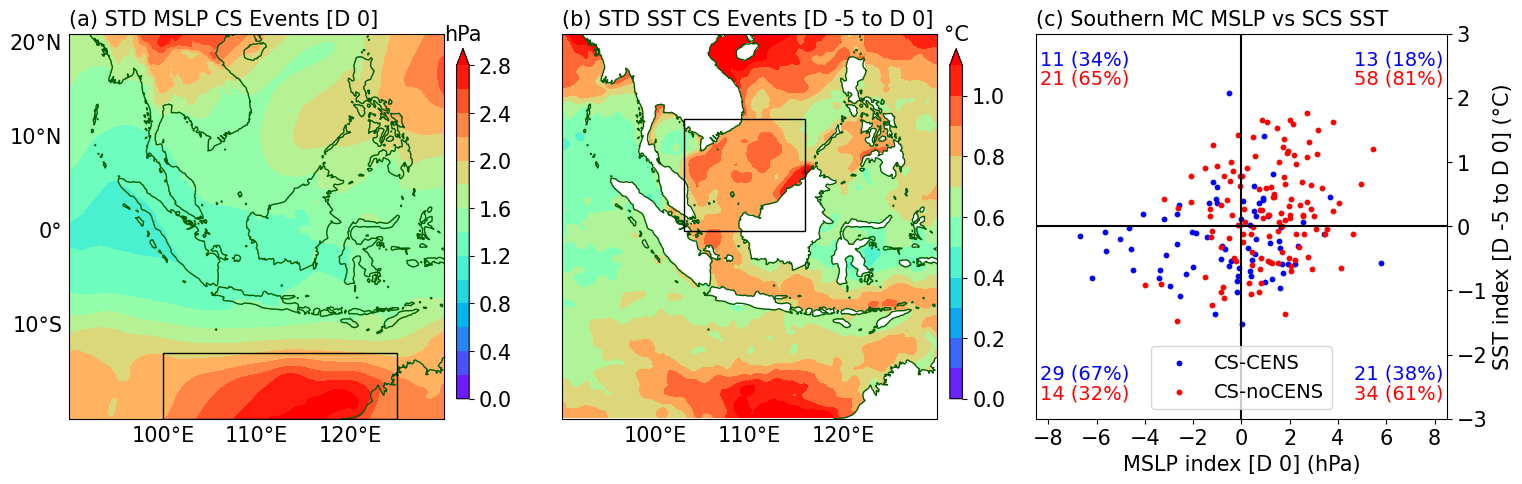

In [60]:
#Plot MSLP Composite
fig=plt.figure(figsize=(18,5))
#gs = gridspec.GridSpec(1, 3, width_ratios=[1,1, 1]) 
axs=plt.subplot(131, projection=ccrs.PlateCarree())
gl=axs.gridlines(draw_labels=True,linewidth=0)
axs.set_extent([90, 130, -19, 20])
gl.top_labels = False
gl.right_labels = False
gl.xlocator = tk.FixedLocator([100, 110, 120])
gl.ylocator = tk.FixedLocator([-10, 0, 10, 20])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
valuetp=slpdjfclim.sel(time=np.in1d(slpdjfclim.time, csevt.index)).std(dim='time')
plotvaltp=axs.contourf(lon, lat, valuetp, transform=ccrs.PlateCarree(),
          cmap='rainbow',
          levels=np.arange(0,3,0.2), 
          extend='max'
          )

longitude1, latitude1 = 100, -20
longitude2, latitude2 = 125, -13

axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='None', edgecolor='k', linewidth=1, zorder=3,
                                transform=ccrs.PlateCarree()))


axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')


axs.set_title('(a) STD MSLP CS Events [D 0]', loc='left', fontsize=15)
    

cbar_tp = fig.add_axes([0.35, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_title('hPa', fontsize=15)

axs=plt.subplot(132, projection=ccrs.PlateCarree())
gl=axs.gridlines(draw_labels=True,linewidth=0)
axs.set_extent([90, 130, -19, 20])
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = tk.FixedLocator([100, 110, 120])
gl.ylocator = tk.FixedLocator([-10, 0, 10, 20])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
sstroll=sstdjfclim.rolling(time=6).mean()
valuetp=sstroll.sel(time=np.in1d(sstroll.time, csevt.index)).std(dim='time')
plotvaltp=axs.contourf(lonsst, latsst, valuetp, transform=ccrs.PlateCarree(),
          cmap='rainbow',
          levels=np.arange(0,1.2,0.1), 
          extend='max'
          )

longitude1, latitude1 = 103, 0
longitude2, latitude2 = 116, 12

axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='None', edgecolor='k', linewidth=1, zorder=3,
                                transform=ccrs.PlateCarree()))


axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')


axs.set_title('(b) STD SST CS Events [D -5 to D 0]', loc='left', fontsize=15)
    

cbar_tp = fig.add_axes([0.624, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_title('°C', fontsize=15)


idxslp=slpdjfclim.sel(lon=slice(100,125), lat=slice(-20,-13)).mean(dim=('lat','lon'))
idxsst=sstdjfclim.sel(lon=slice(103,116), lat=slice(0,12)).mean(dim=('lat','lon'))
idxsst=idxsst.rolling(time=6).mean()

grp=[]
for time in csevt.index:
    if idxslp.sel(time=time)>=0 and idxsst.sel(time=time-np.timedelta64(0,'D'))>=0:
        grp.append(1)
    elif idxslp.sel(time=time)>=0 and idxsst.sel(time=time-np.timedelta64(0,'D'))<0:
        grp.append(2)
    elif idxslp.sel(time=time)<0 and idxsst.sel(time=time-np.timedelta64(0,'D'))<0:
        grp.append(3)
    elif idxslp.sel(time=time)<0 and idxsst.sel(time=time-np.timedelta64(0,'D'))>=0:
        grp.append(4)
csevt['gslpsst']=grp

plt.subplot(133)
plt.title('(c) Southern MC MSLP vs SCS SST', fontsize=15, loc='left')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel('SST index [D -5 to D 0] (°C)', fontsize=15)
plt.xlabel('MSLP index [D 0] (hPa)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=0, c='k')
plt.axhline(y=0, c='k')
plt.xlim([-8.5, 8.5])
plt.ylim([-3, 3])
x = idxslp.sel(time=csevt[csevt['censevt']==1].index-np.timedelta64(0,'D'))
y = idxsst.sel(time=csevt[csevt['censevt']==1].index-np.timedelta64(0,'D'))
xy = np.vstack([x,y])
z = gaussian_kde(xy)
xx, yy = np.meshgrid(np.arange(idxslp.sel(time=csevt.index).min()-1,idxslp.sel(time=csevt.index).max()+1,0.05), 
                     np.arange(idxsst.sel(time=csevt.index).min()-1,idxsst.sel(time=csevt.index).max()+1,0.05))
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(z(positions).T, xx.shape)
#con1=plt.contour(xx, yy, f, colors='b', linewidths=0.5)
plt.scatter(x,y, s=10, c='b', label='CS-CENS')

x = idxslp.sel(time=csevt[csevt['censevt']==0].index-np.timedelta64(0,'D'))
y = idxsst.sel(time=csevt[csevt['censevt']==0].index-np.timedelta64(0,'D'))
xy = np.vstack([x,y])
z = gaussian_kde(xy)
xx, yy = np.meshgrid(np.arange(idxslp.sel(time=csevt.index).min()-1,idxslp.sel(time=csevt.index).max()+1,0.05), 
                     np.arange(idxsst.sel(time=csevt.index).min()-1,idxsst.sel(time=csevt.index).max()+1,0.05))
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(z(positions).T, xx.shape)
#con1=plt.contour(xx, yy, f, colors='r', linewidths=0.5)
plt.scatter(x,y, s=10, c='r', label='CS-noCENS')

for reg, xloc, yloc in zip([1,2,3,4],[1,1,-1,-1],[1,-1,-1,1]):
    nnocens=(np.logical_and(csevt['censevt']==0,csevt['gslpsst']==reg)*1).sum()
    ncens=(np.logical_and(csevt['censevt']==1,csevt['gslpsst']==reg)*1).sum()
    allreg=nnocens+ncens
    if yloc==1:
        loca=2.6
        locb=2.3
    else:
        locb=2.6
        loca=2.3
    plt.text(xloc*6.5,yloc*loca,str(ncens)+' ('+str(int(ncens/allreg*100))+'%)', c='b', ha='center', va='center', fontsize=14)
    plt.text(xloc*6.5,yloc*locb,str(nnocens)+' ('+str(int(nnocens/allreg*100))+'%)', c='r', ha='center', va='center', fontsize=14)
plt.legend(loc='lower center', fontsize=14)

fig.subplots_adjust(wspace=0.2)
#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/12_SMC MSLP vs SCS SST.jpg', dpi=300, bbox_inches='tight')
plt.show()

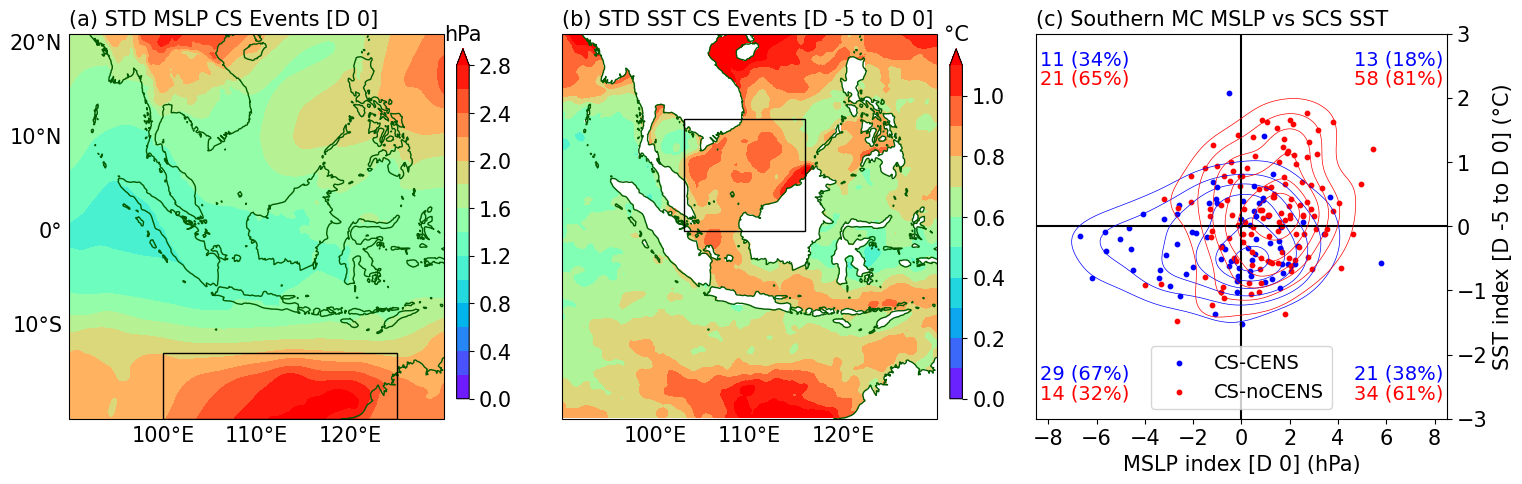

In [11]:
#Plot MSLP Composite
fig=plt.figure(figsize=(18,5))
#gs = gridspec.GridSpec(1, 3, width_ratios=[1,1, 1]) 
axs=plt.subplot(131, projection=ccrs.PlateCarree())
gl=axs.gridlines(draw_labels=True,linewidth=0)
axs.set_extent([90, 130, -19, 20])
gl.top_labels = False
gl.right_labels = False
gl.xlocator = tk.FixedLocator([100, 110, 120])
gl.ylocator = tk.FixedLocator([-10, 0, 10, 20])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
valuetp=slpdjfclim.sel(time=np.in1d(slpdjfclim.time, csevt.index)).std(dim='time')
plotvaltp=axs.contourf(lon, lat, valuetp, transform=ccrs.PlateCarree(),
          cmap='rainbow',
          levels=np.arange(0,3,0.2), 
          extend='max'
          )

longitude1, latitude1 = 100, -20
longitude2, latitude2 = 125, -13

axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='None', edgecolor='k', linewidth=1, zorder=3,
                                transform=ccrs.PlateCarree()))


axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')


axs.set_title('(a) STD MSLP CS Events [D 0]', loc='left', fontsize=15)
    

cbar_tp = fig.add_axes([0.35, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_title('hPa', fontsize=15)

axs=plt.subplot(132, projection=ccrs.PlateCarree())
gl=axs.gridlines(draw_labels=True,linewidth=0)
axs.set_extent([90, 130, -19, 20])
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = tk.FixedLocator([100, 110, 120])
gl.ylocator = tk.FixedLocator([-10, 0, 10, 20])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
sstroll=sstdjfclim.rolling(time=6).mean()
valuetp=sstroll.sel(time=np.in1d(sstroll.time, csevt.index)).std(dim='time')
plotvaltp=axs.contourf(lonsst, latsst, valuetp, transform=ccrs.PlateCarree(),
          cmap='rainbow',
          levels=np.arange(0,1.2,0.1), 
          extend='max'
          )

longitude1, latitude1 = 103, 0
longitude2, latitude2 = 116, 12

axs.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                facecolor='None', edgecolor='k', linewidth=1, zorder=3,
                                transform=ccrs.PlateCarree()))


axs.add_feature(cfeature.COASTLINE, edgecolor='#005a00')


axs.set_title('(b) STD SST CS Events [D -5 to D 0]', loc='left', fontsize=15)
    

cbar_tp = fig.add_axes([0.624, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_title('°C', fontsize=15)


idxslp=slpdjfclim.sel(lon=slice(100,125), lat=slice(-20,-13)).mean(dim=('lat','lon'))
idxsst=sstdjfclim.sel(lon=slice(103,116), lat=slice(0,12)).mean(dim=('lat','lon'))
idxsst=idxsst.rolling(time=6).mean()

grp=[]
for time in csevt.index:
    if idxslp.sel(time=time)>=0 and idxsst.sel(time=time-np.timedelta64(0,'D'))>=0:
        grp.append(1)
    elif idxslp.sel(time=time)>=0 and idxsst.sel(time=time-np.timedelta64(0,'D'))<0:
        grp.append(2)
    elif idxslp.sel(time=time)<0 and idxsst.sel(time=time-np.timedelta64(0,'D'))<0:
        grp.append(3)
    elif idxslp.sel(time=time)<0 and idxsst.sel(time=time-np.timedelta64(0,'D'))>=0:
        grp.append(4)
csevt['gslpsst']=grp

plt.subplot(133)
plt.title('(c) Southern MC MSLP vs SCS SST', fontsize=15, loc='left')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel('SST index [D -5 to D 0] (°C)', fontsize=15)
plt.xlabel('MSLP index [D 0] (hPa)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=0, c='k')
plt.axhline(y=0, c='k')
plt.xlim([-8.5, 8.5])
plt.ylim([-3, 3])
x = idxslp.sel(time=csevt[csevt['censevt']==1].index-np.timedelta64(0,'D'))
y = idxsst.sel(time=csevt[csevt['censevt']==1].index-np.timedelta64(0,'D'))
xy = np.vstack([x,y])
z = gaussian_kde(xy)
xx, yy = np.meshgrid(np.arange(idxslp.sel(time=csevt.index).min()-1,idxslp.sel(time=csevt.index).max()+1,0.05), 
                     np.arange(idxsst.sel(time=csevt.index).min()-1,idxsst.sel(time=csevt.index).max()+1,0.05))
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(z(positions).T, xx.shape)
con1=plt.contour(xx, yy, f, colors='b', linewidths=0.5)
plt.scatter(x,y, s=10, c='b', label='CS-CENS')

x = idxslp.sel(time=csevt[csevt['censevt']==0].index-np.timedelta64(0,'D'))
y = idxsst.sel(time=csevt[csevt['censevt']==0].index-np.timedelta64(0,'D'))
xy = np.vstack([x,y])
z = gaussian_kde(xy)
xx, yy = np.meshgrid(np.arange(idxslp.sel(time=csevt.index).min()-1,idxslp.sel(time=csevt.index).max()+1,0.05), 
                     np.arange(idxsst.sel(time=csevt.index).min()-1,idxsst.sel(time=csevt.index).max()+1,0.05))
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(z(positions).T, xx.shape)
con1=plt.contour(xx, yy, f, colors='r', linewidths=0.5)
plt.scatter(x,y, s=10, c='r', label='CS-noCENS')

for reg, xloc, yloc in zip([1,2,3,4],[1,1,-1,-1],[1,-1,-1,1]):
    nnocens=(np.logical_and(csevt['censevt']==0,csevt['gslpsst']==reg)*1).sum()
    ncens=(np.logical_and(csevt['censevt']==1,csevt['gslpsst']==reg)*1).sum()
    allreg=nnocens+ncens
    if yloc==1:
        loca=2.6
        locb=2.3
    else:
        locb=2.6
        loca=2.3
    plt.text(xloc*6.5,yloc*loca,str(ncens)+' ('+str(int(ncens/allreg*100))+'%)', c='b', ha='center', va='center', fontsize=14)
    plt.text(xloc*6.5,yloc*locb,str(nnocens)+' ('+str(int(nnocens/allreg*100))+'%)', c='r', ha='center', va='center', fontsize=14)
plt.legend(loc='lower center', fontsize=14)

fig.subplots_adjust(wspace=0.2)
#plt.savefig('E:\. Disertasi S3 Bismillah\Publikasi\Paper Hubungan CS dan CENS\Gambar/12_SMC MSLP vs SCS SST v2.jpg', dpi=300, bbox_inches='tight')
plt.show()